In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
print(tf.__version__)

2.2.0


In [117]:
def export_csv():
    # Left lower extremity
    res = {}

    # # Annotations and Metadata
    # res['GRF_Annotation'] = pd.read_csv(r'https://s3-eu-west-1.amazonaws.com/pstorage-npg-968563215/22062960/GRF_metadata.csv')

    # Left lower extremity
    #res['GRF_F_V_PRO_left'] = pd.read_csv(r'GRF_F_V_PRO_left.csv')

    #res['GRF_F_AP_PRO_left'] = pd.read_csv(r'GRF_F_AP_PRO_left.csv')

    #res['GRF_F_ML_PRO_left'] = pd.read_csv(r'GRF_F_ML_PRO_left.csv')

    # res['GRF_COP_AP_PRO_left'] = pd.read_csv(r'GRF_COP_AP_PRO_left.csv')

    # res['GRF_COP_ML_PRO_left'] = pd.read_csv(r'GRF_COP_ML_PRO_left.csv')

    # Right lower extremity
    #res['GRF_F_V_PRO_right'] = pd.read_csv(r'GRF_F_V_PRO_right.csv')

    #res['GRF_F_AP_PRO_right'] = pd.read_csv(r'GRF_F_AP_PRO_right.csv')

    res['GRF_F_ML_PRO_right'] = pd.read_csv(r'GRF_F_ML_PRO_right.csv')

    #res['GRF_COP_AP_PRO_right'] = pd.read_csv(r'GRF_COP_AP_PRO_right.csv')

    #res['GRF_COP_ML_PRO_right'] = pd.read_csv(r'GRF_COP_ML_PRO_right.csv')

    # Annotations and Metadata
    res['GRF_Annotation'] = pd.read_csv(r'GRF_metadata.csv')
    return res

In [118]:
df_dict = export_csv()

In [119]:
df_dict

{'GRF_F_ML_PRO_right':        SUBJECT_ID  SESSION_ID  TRIAL_ID  F_ML_PRO_1  F_ML_PRO_2  F_ML_PRO_3  \
 0             510         413         1   -0.002149   -0.004597   -0.007017   
 1             510         413         2   -0.004095   -0.007960   -0.010888   
 2             510         413         3   -0.002118   -0.005818   -0.010251   
 3             510         413         4   -0.003031   -0.007276   -0.012888   
 4             510         413         6   -0.005082   -0.010662   -0.016314   
 ...           ...         ...       ...         ...         ...         ...   
 75727          93   999910375         6   -0.003705   -0.010468   -0.019982   
 75728          93   999910375         7   -0.004904   -0.012351   -0.022487   
 75729          93   999910375         9   -0.002369   -0.007711   -0.015523   
 75730          93   999910375        10   -0.004149   -0.011612   -0.022090   
 75731          93   999910375        11   -0.002732   -0.007386   -0.014297   
 
        F_ML_PRO

In [120]:
def getTitle(label):
    if label=="HC":
        return "Healthy Controls"
    elif label=="K":
        return "Knee impairment "
    elif label=="A":
        return "Ankle impairment"
    elif label=="H":
        return "Hip impairment"
    else:
        return "Calcaneus impairment"

In [121]:
# df_dict['GRF_F_V_PRO_left']
# df_dict['GRF_Annotation']
# subject_id = df_dict['GRF_Annotation']["SUBJECT_ID"].unique()
# subject_id = pd.DataFrame({"SUBJECT_ID": subject_id})
# grf = subject_id.merge(grf, on="SUBJECT_ID", how = "inner")

In [122]:
#df_dict['GRF_F_V_PRO_left']['SUBJECT_ID'].loc['']

In [123]:
def get_Inputs(grf, meta, label):
  subject_id = meta.loc[meta["CLASS_LABEL"]==label]["SUBJECT_ID"].unique()
  subject_id = pd.DataFrame({"SUBJECT_ID": subject_id})
  grf = subject_id.merge(grf, on="SUBJECT_ID", how = "inner")
  #grf = grf.drop_duplicates(['SUBJECT_ID'], keep = 'first')
  #grf.drop(grf.columns[:3], axis = 1)
  grf = grf.iloc[:,3:].values
  res = np.array(grf)
  return res

In [124]:
X = None
for key in df_dict:
  if key== 'GRF_Annotation': 
    continue
  temp = get_Inputs(df_dict[key], df_dict['GRF_Annotation'], 'HC')#shape (7755, 104)
  if X is None:
    X = temp
  else:
    X = np.append(X, temp, axis=0)
print(X.shape)
#X = get_Inputs(df_dict['GRF_F_V_PRO_left'], df_dict['GRF_Annotation'], 'HC')#shape (7755, 104)
#X = X[0,:].reshape(1, 104)
#X.shape
print(type(X))

(7755, 101)
<class 'numpy.ndarray'>


In [125]:
scaler = MinMaxScaler(feature_range=(0, 1))
print('X', X)
X = scaler.fit_transform(X)
print('X_new', X)

X [[ 0.00092281 -0.001528   -0.00633684 ... -0.01009653 -0.00681242
  -0.00370574]
 [-0.00498914 -0.01181551 -0.02191771 ... -0.00810007 -0.0053698
  -0.00270015]
 [ 0.0008356  -0.00042061 -0.0039916  ... -0.00833721 -0.00522617
  -0.00252099]
 ...
 [ 0.00073336  0.0004424  -0.00084659 ...  0.00101174  0.00205632
   0.00245104]
 [-0.00129361 -0.00265374 -0.00505646 ...  0.0060628   0.00568711
   0.00473138]
 [-0.00283512 -0.00361729 -0.00469243 ...  0.00607024  0.0059795
   0.00528578]]
X_new [[0.65345432 0.68273052 0.69326614 ... 0.28120698 0.26552636 0.29027086]
 [0.45598893 0.5142267  0.53558708 ... 0.32019063 0.29999399 0.32061529]
 [0.65054133 0.70086885 0.71700007 ... 0.31556022 0.30342546 0.32602167]
 ...
 [0.64712633 0.71500446 0.74882771 ... 0.49811079 0.47742096 0.47605734]
 [0.57942334 0.66429149 0.70622363 ... 0.5967396  0.56416898 0.54486896]
 [0.52793555 0.64850898 0.70990767 ... 0.59688489 0.57115468 0.56159836]]


In [126]:
l1, l2 = 0.6, 0.9
X_train = X[0:(int)(X.shape[0]*l1), :]
X_val = X[(int)(X.shape[0]*l1):(int)(X.shape[0]*l2), :]
X_test = X[(int)(X.shape[0]*l2):, :]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4653, 101)
(2326, 101)
(776, 101)


In [127]:
#X = get_Inputs(df_dict['GRF_F_V_PRO_left'], df_dict['GRF_Annotation'], 'A')

In [128]:
# def get_data_series(X, serie_size):
#     first_step = X.shape[1] - serie_size - 1
#     last_step = X.shape[1]
#     data_series = []

#     for row in X:
#         for step1 in range((last_step - (first_step + serie_size)) + 1):
#             serie = []
#             for step2 in range(serie_size):
#                 serie.append(row[step1 + first_step + step2])
#             data_series.append(serie)
#     return np.squeeze(np.array(data_series)), np.squeeze(np.zeros(np.array(data_series).shape))
def get_data_series(X, serie_size):
    #first_step = 0 #X.shape[1] - serie_size - 1
    print(X.shape)
    last_step = X.shape[1]
    data_series = []
    for row in X:
        for step1 in range(last_step - serie_size):
            serie = row[step1 : step1 + serie_size]
            # for step2 in range(serie_size):
            #     serie.append(row[step1 + step2])
            data_series.append(serie)
    res = np.array(np.squeeze(np.array(data_series)))
    print(res.shape)
    return res

In [129]:
# X_new = get_data_series(X, 10)
# X_new = X_new.reshape(X_new.shape[0], X_new.shape[1], 1)
# X_new.shape
X_train, X_val, X_test = get_data_series(X_train, 16),get_data_series(X_val, 16) ,get_data_series(X_test, 16)

X_train, X_val, X_test = X_train.reshape(X_train.shape[0], X_train.shape[1], 1),X_val.reshape(X_val.shape[0], X_val.shape[1], 1), X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print('X_train.shape ',X_train.shape)
print('X_val.shape ',X_val.shape)
print('X_test.shape ',X_test.shape)

(4653, 101)
(395505, 16)
(2326, 101)
(197710, 16)
(776, 101)
(65960, 16)
X_train.shape  (395505, 16, 1)
X_val.shape  (197710, 16, 1)
X_test.shape  (65960, 16, 1)


In [130]:
serie_size  =  X_train.shape[1] # equal to the lookback
n_features =  X_train.shape[2] # 1

epochs = 150
batch = 128
lr = 0.001

In [55]:
#using LSTM-AE
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(serie_size, activation='relu', input_shape=(serie_size, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(8, activation='relu', return_sequences=True))
#lstm_autoencoder.add(LSTM(8, activation='relu'))
lstm_autoencoder.add(LSTM(4, activation='relu'))
lstm_autoencoder.add(RepeatVector(serie_size))
# lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
# lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
# lstm_autoencoder.add(RepeatVector(serie_size))
# # Decoder
# lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
# lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(8, activation='relu', return_sequences=True))
#lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(serie_size, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 16, 16)            1152      
_________________________________________________________________
lstm_11 (LSTM)               (None, 16, 8)             800       
_________________________________________________________________
lstm_12 (LSTM)               (None, 4)                 208       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 16, 4)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 16, 8)             416       
_________________________________________________________________
lstm_14 (LSTM)               (None, 16, 16)            1600      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 1)            

In [112]:
hidden_size = 32
code_size = 4

In [131]:
from tensorflow.keras.layers import Input, Dense
from keras import regularizers

dnn_autoencoder = Sequential()
dnn_autoencoder.add(Input(shape=(serie_size,1)))
dnn_autoencoder.add(Dense(hidden_size, activation='relu'))
dnn_autoencoder.add(Dense(code_size, activation='relu',activity_regularizer=regularizers.l1(10e-6)))
dnn_autoencoder.add(Dense(hidden_size, activation='relu'))
dnn_autoencoder.add(Dense(serie_size, activation='sigmoid'))
dnn_autoencoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 16, 32)            64        
_________________________________________________________________
dense_21 (Dense)             (None, 16, 4)             132       
_________________________________________________________________
dense_22 (Dense)             (None, 16, 32)            160       
_________________________________________________________________
dense_23 (Dense)             (None, 16, 16)            528       
Total params: 884
Trainable params: 884
Non-trainable params: 0
_________________________________________________________________


In [132]:
adam = optimizers.Adam(lr)
dnn_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier_n.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

dnn_autoencoder_history = dnn_autoencoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch,
                                                validation_data=(X_val, X_val),
                                                verbose=2).history

Epoch 1/150
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set th

Epoch 91/150
3090/3090 - 42s - loss: 4.9199e-06 - val_loss: 3.8121e-06
Epoch 92/150
3090/3090 - 42s - loss: 5.0381e-06 - val_loss: 1.0386e-05
Epoch 93/150
3090/3090 - 43s - loss: 5.0456e-06 - val_loss: 3.8975e-06
Epoch 94/150
3090/3090 - 42s - loss: 5.0217e-06 - val_loss: 4.6135e-06
Epoch 95/150
3090/3090 - 41s - loss: 5.0028e-06 - val_loss: 3.8799e-06
Epoch 96/150
3090/3090 - 40s - loss: 4.9504e-06 - val_loss: 3.7824e-06
Epoch 97/150
3090/3090 - 40s - loss: 5.0312e-06 - val_loss: 3.7552e-06
Epoch 98/150
3090/3090 - 40s - loss: 4.9612e-06 - val_loss: 3.7724e-06
Epoch 99/150
3090/3090 - 40s - loss: 4.9217e-06 - val_loss: 3.8618e-06
Epoch 100/150
3090/3090 - 40s - loss: 5.0232e-06 - val_loss: 4.3045e-06
Epoch 101/150
3090/3090 - 40s - loss: 4.8473e-06 - val_loss: 3.8626e-06
Epoch 102/150
3090/3090 - 40s - loss: 4.9403e-06 - val_loss: 3.7952e-06
Epoch 103/150
3090/3090 - 39s - loss: 4.8824e-06 - val_loss: 3.7943e-06
Epoch 104/150
3090/3090 - 40s - loss: 4.9330e-06 - val_loss: 4.5552e-06
E

In [134]:
dnn_autoencoder.save('auto_230421_right_ML.h5')

In [40]:
import matplotlib

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
#matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=BIGGER_SIZE)
matplotlib.rc('axes', labelsize=BIGGER_SIZE)
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE) 

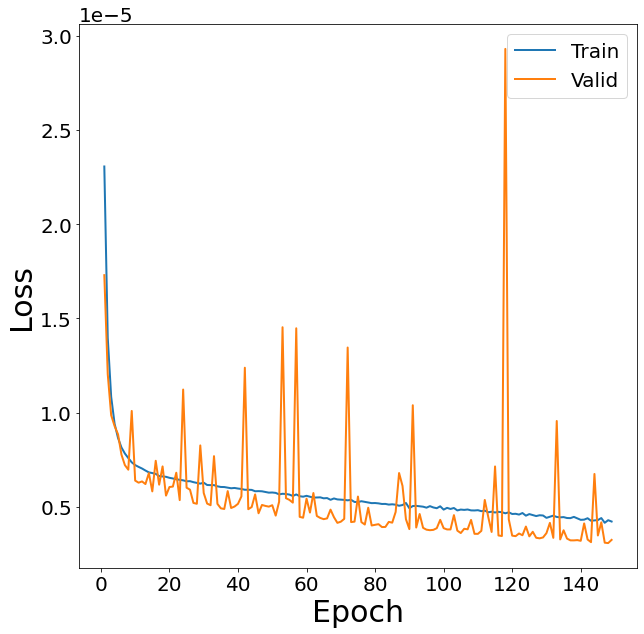

In [133]:
start = 1
plt.figure(figsize= (10,10))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
loss_train = dnn_autoencoder_history['loss'][start:]
plt.plot(np.arange(start, len(dnn_autoencoder_history['loss'])), loss_train, linewidth=2, label='Train')
loss_valid = dnn_autoencoder_history['val_loss'][start:]
plt.plot(np.arange(start, len(dnn_autoencoder_history['loss'])), loss_valid, linewidth=2, label='Valid')
plt.legend(loc='upper right')
#plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig("loss_plot_right_ml_ae.png")
plt.show()

In [ ]:
ae_loss_left_V = 1.4808e-05
ae_loss_left_AP = 
ae_loss_left_ML = 4.2494e-06
ae_loss_right_V = 1.1084e-05
ae_loss_right_AP = 4.1992e-06
ae_loss_right_ML = 3.2405e-06

In [ ]:
def flatten(X):
    '''
    Flatten a 3D array.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [ ]:
#X_test = X_new
valid_x_predictions = lstm_autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - valid_x_predictions, 2), axis=1)

error_df = pd.DataFrame({'prediction_error': mse,
                         'Predicted_class': flatten(valid_x_predictions).tolist(),
                        'True_class': flatten(X_test).tolist()})

ax = error_df.plot()
ax.set_xlabel('Inputs')
ax.set_ylabel('mean sq. prediction_error')


In [ ]:
while True:
  x = 1